# **Part A**
Count / Frequency based Naive Bayes Classifier

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

def load_pubmed_rct_file(filepath):
    """
    Reads a .txt file from the PubMed 20k RCT dataset.
    Returns a DataFrame with 'label' and 'sentence'.
    """
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})

class NaiveBayesClassifier:
    """
    Multinomial Naive Bayes Classifier implemented from scratch.
    Suitable for Count and TF-IDF features.
    """
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        for c in self.classes:
            X_c = X_counts[y_array == c]

            # Calculate log prior: log(P(C))
            # P(C) = (number of samples in class c) / (total number of samples)
            self.class_priors[c] = np.log(X_c.shape[0] / X_counts.shape[0])

            # Compute total count of each word in class c
            feature_sum = X_c.sum(axis=0).A1  # Converts to 1D array
            total_mass = np.sum(feature_sum)

            # Apply Laplace smoothing
            numerator = feature_sum + self.alpha
            denominator = total_mass + self.alpha * self.vocabulary_size

            # Calculate log likelihood: log(P(w_i | C))
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []

        for i in range(X_counts.shape[0]):
            scores = {}
            x_i = X_counts.getrow(i)

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                # Add contribution from each word (Multinomial NB formula)
                # log(P(C|x)) ∝ log(P(C)) + Σ count(w_i) * log(P(w_i|C))
                log_prob += x_i.data @ log_likelihoods[x_i.indices]

                scores[c] = log_prob

            # Pick the class with the highest log probability
            predicted_class = max(scores, key=scores.get)
            y_pred.append(predicted_class)

        # Return predictions as numpy array
        return np.array(y_pred)

In [4]:
# Load and Prepare Data (DO NOT CHANGE)
dir_path = './'
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))

    # train_df = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    # dev_df   = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    # test_df  = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})

    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []

Train samples: 180040
Dev   samples: 30212
Test  samples: 30135
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [5]:
if X_train is not None and len(X_train) > 0:

    # Initialize and fit the CountVectorizer for count-based features
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        # Using unigrams + bigrams for better text representation
        ngram_range=(1, 2),
        # Safe minimum document frequency (keeps rare words)
        min_df=1
    )

    print("Fitting Count Vectorizer and transforming training data...")

    # Fit the vectorizer on X_train and transform
    X_train_counts = count_vectorizer.fit_transform(X_train)

    if X_train_counts is not None:
        print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    # Transform X_test using the fitted vectorizer
    X_test_counts = count_vectorizer.transform(X_test)

    # Train Custom Naive Bayes Classifier
    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")
    nb_model = NaiveBayesClassifier(alpha=1.0)

    # Fit the model using X_train_counts and y_train
    nb_model.fit(X_train_counts, y_train)

    print("Training complete.")

else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")

Fitting Count Vectorizer and transforming training data...
Vocabulary size: 1108611
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.


In [6]:
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

# Predict y_test_pred using X_test_counts
y_test_pred = nb_model.predict(X_test_counts)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")


=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7431
              precision    recall  f1-score   support

  BACKGROUND       0.61      0.46      0.53      3621
 CONCLUSIONS       0.65      0.62      0.63      4571
     METHODS       0.74      0.91      0.82      9897
   OBJECTIVE       0.67      0.29      0.41      2333
     RESULTS       0.83      0.84      0.84      9713

    accuracy                           0.74     30135
   macro avg       0.70      0.63      0.64     30135
weighted avg       0.74      0.74      0.73     30135

Macro-averaged F1 score: 0.6446


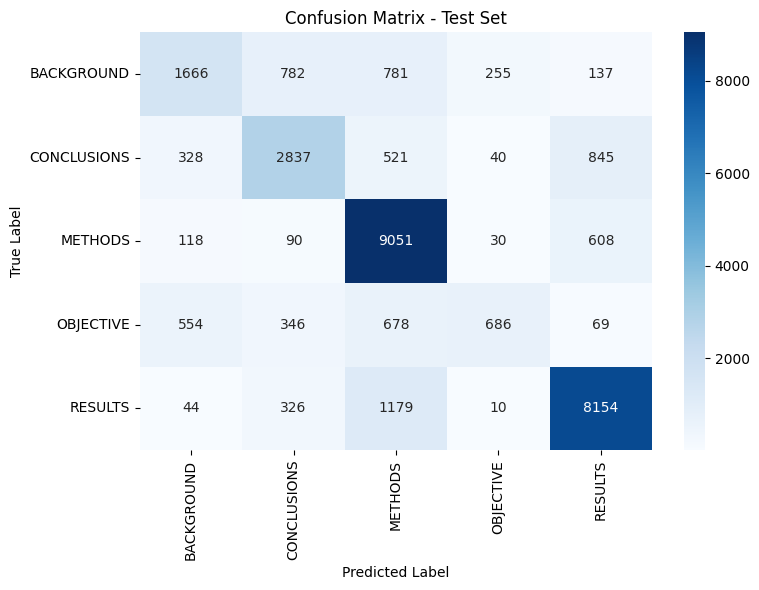

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate and visualize the confusion matrix
if y_test_pred is not None:
    cm = confusion_matrix(y_test, y_test_pred, labels=target_names)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix - Test Set")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()
else:
    print("Confusion matrix cannot be generated: y_test_pred is None.")

# **Part B**
TF-IDF score based Classifier

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO Implementation (All Completed)
# =======================================================

# Define a Pipeline using TfidfVectorizer and MultinomialNB
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        lowercase=True,
        stop_words='english'
    )),
    ('nb', MultinomialNB())
])

# Train the initial pipeline
print("Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")


# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = pipeline.predict(X_test)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
else:
    print("Initial model evaluation skipped: Predictions not available.")


# =======================================================
# Hyperparameter Tuning using GridSearchCV
# =======================================================

# Define the parameter grid
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__min_df': [1, 2],
    'nb__alpha': [0.1, 0.5, 1.0]
}

# Dynamically adjust CV folds based on dev data size
cv_folds = 3 if len(X_dev) >= 3 else max(1, len(X_dev))

# Initialize GridSearchCV
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv_folds,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

print("\nStarting Hyperparameter Tuning on Development Set...")
grid.fit(X_dev, y_dev)
print("Grid search complete.")


# Display best parameters and score
if grid is not None and hasattr(grid, 'best_params_'):
    print("\n=== Best Model Parameters ===")
    print(grid.best_params_)
    print(f"Best Cross-Validation F1 Score: {grid.best_score_:.4f}")
else:
    print("Hyperparameter tuning skipped: Grid Search object not initialized or fitted.")


Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.6996
              precision    recall  f1-score   support

  BACKGROUND       0.61      0.37      0.46      3621
 CONCLUSIONS       0.61      0.55      0.57      4571
     METHODS       0.68      0.88      0.77      9897
   OBJECTIVE       0.72      0.09      0.16      2333
     RESULTS       0.77      0.85      0.81      9713

    accuracy                           0.70     30135
   macro avg       0.68      0.55      0.56     30135
weighted avg       0.69      0.70      0.67     30135

Macro-averaged F1 score: 0.5555

Starting Hyperparameter Tuning on Development Set...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Grid search complete.

=== Best Model Parameters ===
{'nb__alpha': 0.1, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Best Cross-Validation F1 Score: 0.6235


# **Part C**
Bayes Optimal Classifier

Part C Draft

Please enter your full SRN (e.g., PES1UG22CS345): PES2UG23CS185
Using dynamic sample size: 10185
Actual sampled training set size used: 10185

Training all base models...
Training NaiveBayes...
Training LogisticRegression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training RandomForest...
Training DecisionTree...
Training KNN...
All base models trained.

Calculating Posterior Weights (P(h_i | D))...
Evaluating NaiveBayes on validation set...
Evaluating LogisticRegression on validation set...
Evaluating RandomForest on validation set...
Evaluating DecisionTree on validation set...
Evaluating KNN on validation set...
Posterior Weights (normalized):
  NaiveBayes: 0.241
  LogisticRegression: 0.241
  RandomForest: 0.200
  DecisionTree: 0.142
  KNN: 0.176

Fitting the VotingClassifier (BOC approximation)...
Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===
              precision    recall  f1-score   support

  BACKGROUND       0.59      0.31      0.41      3621
 CONCLUSIONS       0.60      0.51      0.55      4571
     METHODS       0.68      0.90      0.77      9897
   OBJECTIVE       0.68      0.31      0.43      2333
     RESULTS       0.78      0.81      0.80      9713

    accuracy   

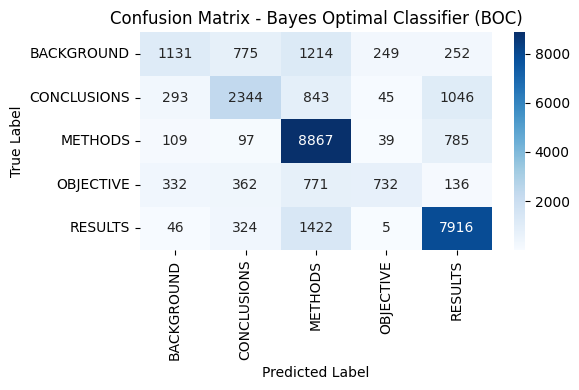

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split  # Used for P(h|D) calculation


# =======================================================
# Dynamic Data Sampling (DO NOT CHANGE)
# =======================================================
BASE_SAMPLE_SIZE = 10000

# Prompt the user for their full SRN
FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")

try:
    # Extract the last three characters and convert to integer
    if len(FULL_SRN) >= 3:
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        raise ValueError("SRN too short.")
except (ValueError, IndexError, TypeError):
    print("WARNING: SRN input failed or format is incorrect. Using 10000.")
    srn_value = 0

# Calculate the final sample size
SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value
print(f"Using dynamic sample size: {SAMPLE_SIZE}")

# Placeholder initialization (if dataset not available)
if 'X_train' not in locals() or len(X_train) == 0:
    print("Warning: Training data not found. Using small placeholder data.")
    X_train = pd.Series(["sample text one"] * 11000)
    y_train = pd.Series(["BACKGROUND"] * 5000 + ["METHODS"] * 6000)
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]

effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")


# =======================================================
# Base TF-IDF parameters (DO NOT CHANGE)
# =======================================================
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1),
    'min_df': 5
}


# =======================================================
# Define the five diverse hypotheses/pipelines (DO NOT CHANGE)
# =======================================================

# H1: Multinomial Naive Bayes
h1_nb = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', MultinomialNB(alpha=1.0, fit_prior=False))
])

# H2: Logistic Regression
h2_lr = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))
])

# H3: Random Forest Classifier
h3_rf = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1), cv=3, method='isotonic'
    ))
])

# H4: Decision Tree Classifier
h4_dt = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        DecisionTreeClassifier(max_depth=10, random_state=42), cv=3, method='isotonic'
    ))
])

# H5: K-Nearest Neighbors
h5_knn = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        KNeighborsClassifier(n_neighbors=5, n_jobs=-1), cv=3, method='isotonic'
    ))
])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']


# =======================================================
# Training and BOC Implementation (TODO SECTIONS)
# =======================================================

# TODO: Train all five hypotheses on X_train_sampled and y_train_sampled
print("\nTraining all base models...")

for name, model in zip(hypothesis_names, hypotheses):
    print(f"Training {name}...")
    model.fit(X_train_sampled, y_train_sampled)

print("All base models trained.")


# TODO: Implement the Posterior Weight Calculation (P(h_i | D))
# This requires splitting X_train_sampled into train_sub and val_sub,
# calculating the validation accuracy for each model, and normalizing.
print("\nCalculating Posterior Weights (P(h_i | D))...")

X_subtrain, X_val, y_subtrain, y_val = train_test_split(
    X_train_sampled, y_train_sampled, test_size=0.2, random_state=42
)

likelihoods = []
for name, model in zip(hypothesis_names, hypotheses):
    print(f"Evaluating {name} on validation set...")
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    likelihoods.append(acc)

posterior_weights = np.array(likelihoods) / np.sum(likelihoods)
posterior_weights = posterior_weights.round(3)

print("Posterior Weights (normalized):")
for name, w in zip(hypothesis_names, posterior_weights):
    print(f"  {name}: {w:.3f}")


# TODO: Fit the VotingClassifier (BOC approximation)
print("\nFitting the VotingClassifier (BOC approximation)...")
boc_soft_voter = VotingClassifier(
    estimators=list(zip(hypothesis_names, hypotheses)),
    voting='soft',
    weights=posterior_weights,
    n_jobs=-1
)
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("Fitting complete.")


# TODO: Predict y_pred using X_test and evaluate
print("\nPredicting on test set...")
y_pred = boc_soft_voter.predict(X_test)


# TODO: Final Evaluation and Visualization
print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")
print(classification_report(y_test, y_pred, target_names=target_names))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Macro F1: {f1_score(y_test, y_pred, average='macro'):.4f}")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title("Confusion Matrix - Bayes Optimal Classifier (BOC)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()